# RNA-Seq Analysis Training Demo

### STEP 1: Library Installation

First install the R packages that will be used. <strong>This installation may take around 15 minutes.</strong>

In [1]:
###install the libraries first, if required
install.packages("BiocManager")

if (!require("ComplexHeatmap"))
    BiocManager::install("ComplexHeatmap")

if (!require("DESeq2"))
    BiocManager::install("DESeq2")

if (!require("EnhancedVolcano"))
    BiocManager::install('EnhancedVolcano')

if (!require("dplyr"))
    install.packages("dplyr")

if (!require("pheatmap"))
    install.packages("pheatmap")

if (!require("ggrepel"))
    install.packages("ggrepel")

if (!require("ggfortify"))
    install.packages("ggfortify")


###load the libraries
library(DESeq2)
library(dplyr)
library(ComplexHeatmap)
library(EnhancedVolcano)
library(ggplot2)
library(ggrepel)
library(ggfortify)

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)

Loading required package: ComplexHeatmap

Loading required package: grid

ComplexHeatmap version 2.12.1
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


Loading required package: DESeq2

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Atta

### STEP 2: Reading in Data

Next read-in the gene count data that will be analyzed.

This read-in step often involves reformatting or adjusting the data.

To make things easier, we created a matrix, or a table, of just our read-count data -- excluding the non-numerical metadata columns. This makes it easy for us to feed this table into the deseq2 tool later on.

Additionally, later on we will use normalization involving logarithms. So, to prevent errors, we will replace all readcount values of '0' in our data, with '1'. This will change the data only slightly, and will prevent these zeroes from causing an 'undefined' or 'N/A' math error in the logarithm normalization step.


In [29]:
#download genecounts and annotation file from cloud storage bucket
system("mkdir -p data/gene_counts", intern=TRUE)
system("mkdir -p data/reference", intern=TRUE)

system("curl https://storage.googleapis.com/kinglab-maine-zfish/Truncated/zebrafish_2020_mrna_counts_mock.txt --output data/gene_counts/zebrafish_2020_mrna_counts_mock.txt", intern=TRUE)
system("curl https://storage.googleapis.com/kinglab-maine-zfish/Reference/biomart_GRCz11_annotation.txt --output data/reference/biomart_GRCz11_annotation.txt", intern=TRUE)


#read-in the raw gene count file to a dataframe variable we named 'read_counts'
read_counts <- read.table('data/gene_counts/zebrafish_2020_mrna_counts_mock.txt',head=TRUE)

#replace all count entries of '0' in the raw gene count file with '1'.
read_counts[read_counts==0] <- 1

#assign the numerical read counts to a matrix variable we named 'rnaseqMatrix'
rnaseqMatrix <- round(read_counts[,c(2:9)])

#label the rownames of this matrix with the rowname column from the gene count dataframe.
rownames(rnaseqMatrix) <- read_counts[,1]

head(rnaseqMatrix)


character(0)

character(0)

character(0)

character(0)

,SA60184,SA60185,SA60186,SA60187,SA60188_trunc,SA60189,SA60190,SA60191
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSDARG00000000001,1,1,1,1,1,1,1,1
ENSDARG00000000002,17,10,12,12,1,1,1,1
ENSDARG00000000018,1,1,1,1,1,1,1,1
ENSDARG00000000019,16,24,35,44,1,1,1,1
ENSDARG00000000068,51,39,59,46,1,1,1,1
ENSDARG00000000069,788,228,233,145,1,1,1,1


### STEP 4: Specifying Experimental Design

Next specify the experimental design. 

The deseq2 tool will later use this design to group samples together, and output information about the statistical differences in gene expression between these specified groups.

In [30]:
# define the sample experimental design, in this case 6 wildtype and 6 bacteriophage infected samples
samples_treatment <- data.frame(matrix(c(rep("WHIM",4),rep("WT",4)),ncol=1))
samples_ID <- data.frame(matrix(colnames(rnaseqMatrix),ncol=1))
samples <- cbind(samples_ID,samples_treatment)
names(samples) <- c("ID","Treatment")
rownames(samples) <- samples[,1]

print("An example of how a deseq2 experimental design table might look.")
samples



[1] "An example of how a deseq2 experimental design table might look."


,ID,Treatment
,<chr>,<chr>
SA60184,SA60184,WHIM
SA60185,SA60185,WHIM
SA60186,SA60186,WHIM
SA60187,SA60187,WHIM
SA60188_trunc,SA60188_trunc,WT
SA60189,SA60189,WT
SA60190,SA60190,WT
SA60191,SA60191,WT


### STEP 5: Creating Deseq2 Object

Now use the treatment design matrix in combination with the readcount matrix to create a deseq2 object. 

Once created, this is also a good opportunity to filter out lowly expresseed genes, and to inspect the pre-normalized data using pairwise comparison plots.

Finally, the deseq2 analysis can be run on the deseq2 object.

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


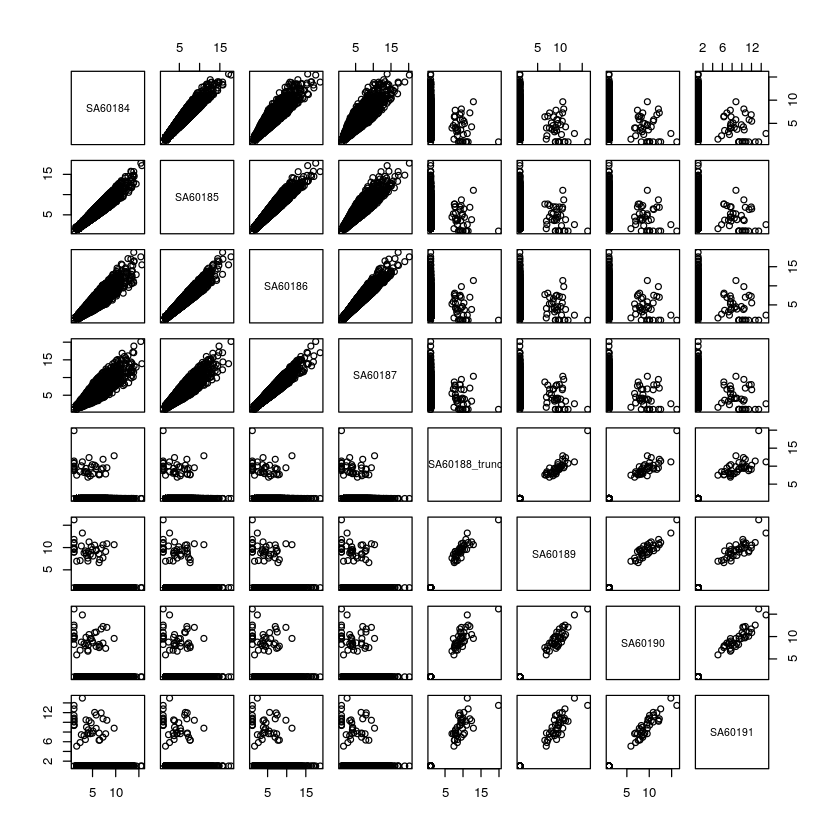

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing



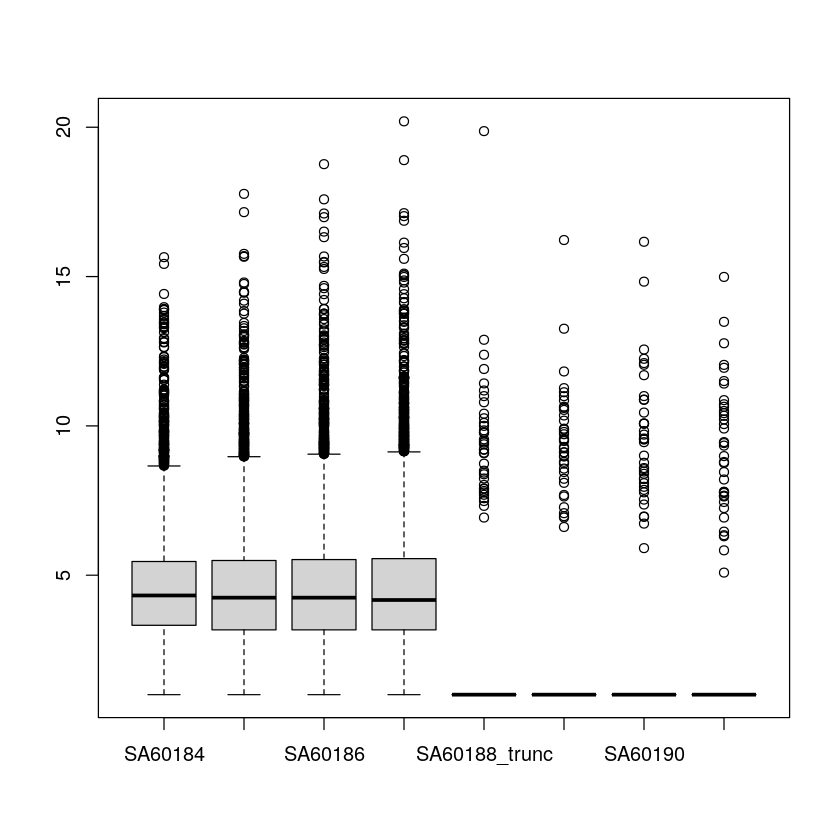

In [31]:
#Create the DEseq2DataSet object
deseq2Data <- DESeqDataSetFromMatrix(countData = rnaseqMatrix, colData = samples, design = ~ Treatment)

# Perform pre-filtering of the data
deseq2Data <- deseq2Data[rowSums(counts(deseq2Data)) > 10, ]

# Inspect pre-normalized data 
pairs(log2((counts(deseq2Data)+1)))
boxplot(log2((counts(deseq2Data)+1)))

# Run pipeline for differential expression steps
deseq2Data <- DESeq(deseq2Data)


### STEP 6: Normalize Data

Now normalize the data using the 'regular normalization' function from deseq2.

Normalization of gene readcounts across samples will help to minimize sample variation noise and ensure more accurate comparisons.

In [32]:
#perform rlog normalization on deseq2 object
rld <- rlog(deseq2Data, blind=FALSE)

#a handy variable so we can easily reference the rlog genecount matrix in the future, as deseq objects contain many tables of data.
rlogcounts <- assay(rld)
rownames(rlogcounts) <- rownames(deseq2Data)

head(rlogcounts)

,SA60184,SA60185,SA60186,SA60187,SA60188_trunc,SA60189,SA60190,SA60191
ENSDARG00000000002,1.916114,1.462440,1.633587,1.662219,1.875744,1.875744,1.875744,1.875744
ENSDARG00000000019,2.145347,2.524776,2.904699,3.166381,2.375727,2.375727,2.375727,2.375727
ENSDARG00000000068,3.401990,3.158894,3.584705,3.368239,2.696239,2.696239,2.696239,2.696239
ENSDARG00000000069,6.698176,5.410173,5.450247,5.014852,3.733501,3.733501,3.733501,3.733501
ENSDARG00000000086,2.807663,2.913424,2.748606,2.711161,2.427379,2.427379,2.427379,2.427379
ENSDARG00000000103,1.938192,1.772269,1.852461,2.256008,2.020855,2.020855,2.020855,2.020855


Normalization of data can is often verified by inspecting by various plots, for instance histograms:

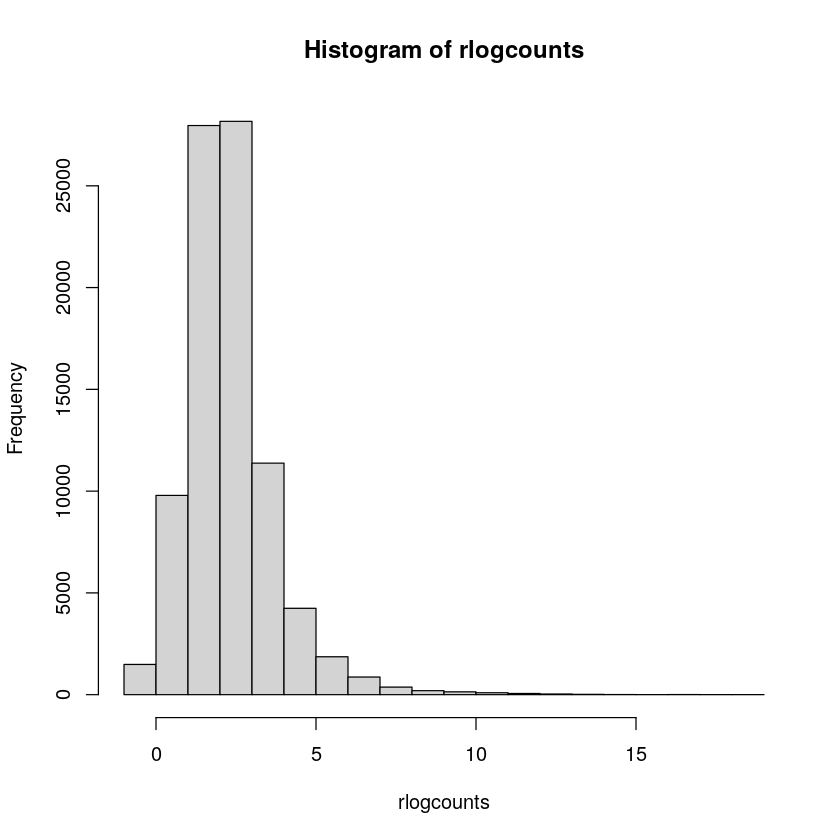

In [33]:
hist(rlogcounts)

Boxplots:

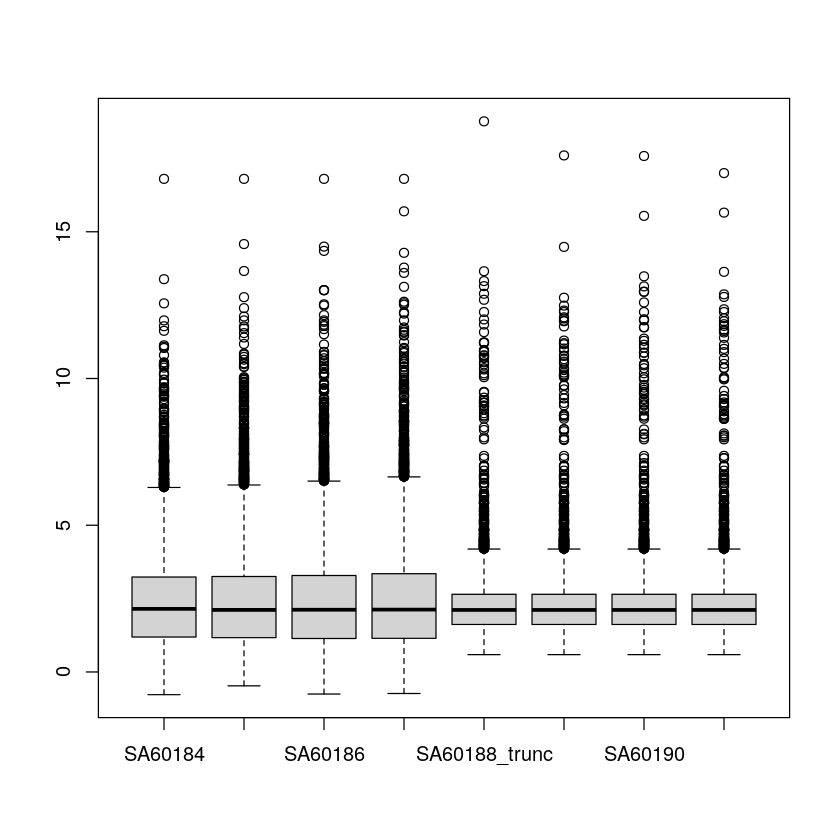

In [34]:
boxplot(rlogcounts)

Or pairwise comparison plots.

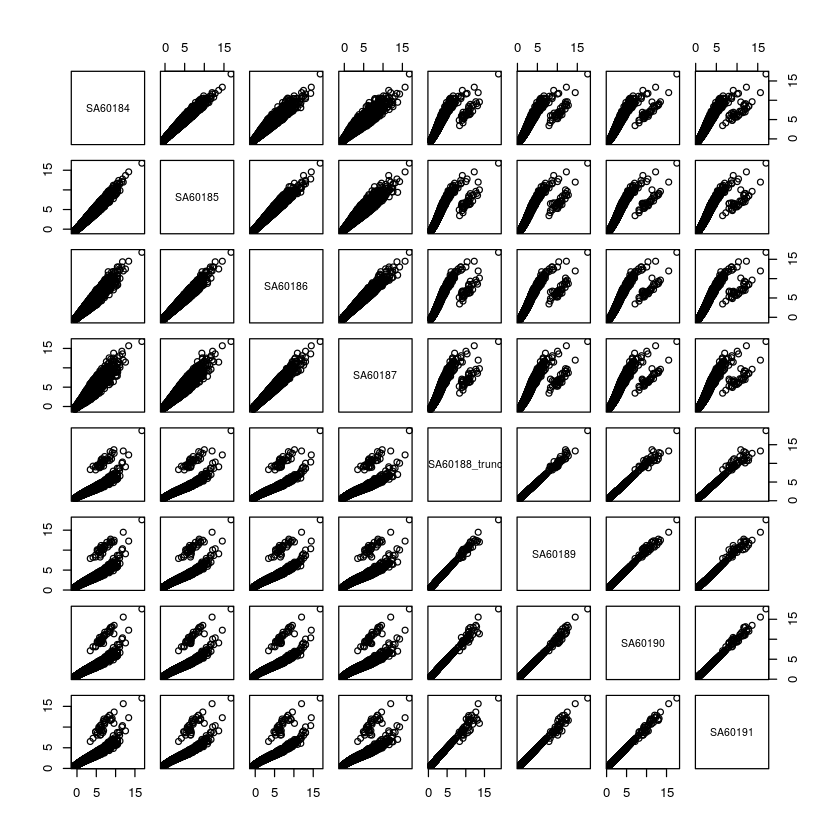

In [35]:
pairs(rlogcounts)

Compare the plots of the pre-normalized and normalized data to see the effect of normalization.

Notice how the samples in the box plot, and in-group samples in the pair plots display similar distributions.

Looking at normalized plots can be an easy way to look out for any obvious inconsistencies or errors in the sample data.

### STEP 7: PCA Plot

We can now begin to produce plots to further analyze the differences between groups.

PCA plots can be an effective way to visualize variation within and between sample sets.

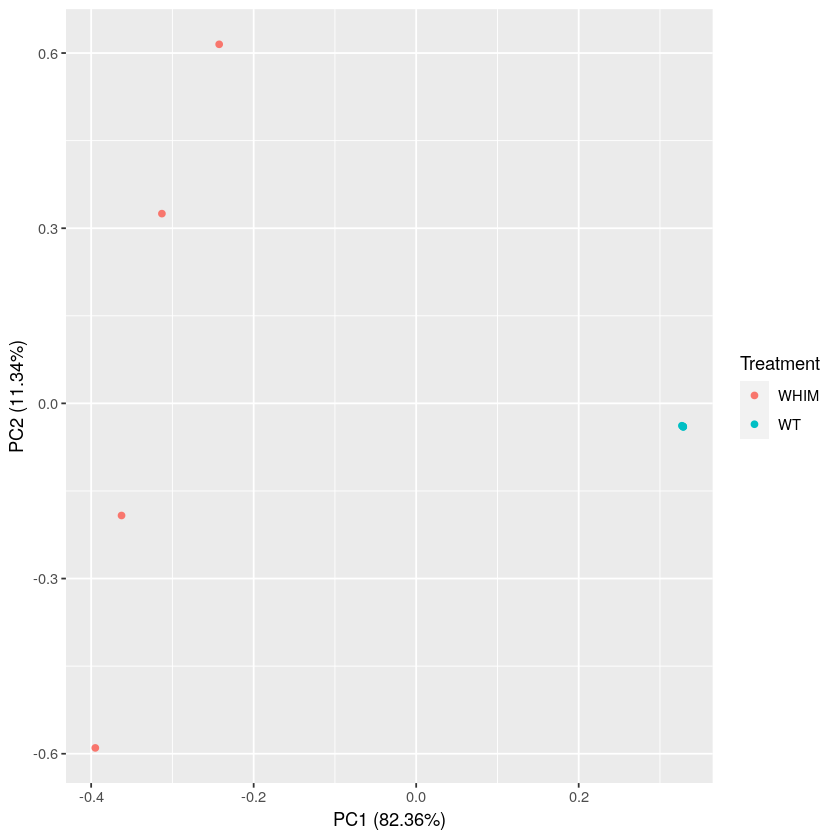

In [36]:
pca_counts <- prcomp(t(rlogcounts))
autoplot(pca_counts, data = samples, colour="Treatment")

Plots can be output as above, or also saved as pdf or image files, as below. Try to navigate and click to the created file, after you run the code.

In [37]:
pdf("data/gene_counts/PCA_Plot.pdf")
autoplot(pca_counts, data = samples, colour="Treatment")
dev.off()

png 
  2

### STEP 8: Contrast Comparisons

Contrast comparisons between two treatment groups can be performed using the deseq2 tool to identify differentially up and down regulated genes.

Using R, these results can be summarized, reordered, and/or trimmed.

In [39]:
#Output the results of comparing WT and WHIM group
res_WT_WHIM <- results(deseq2Data, contrast=c("Treatment","WHIM","WT"))
summary(res_WT_WHIM)
print("Number of genes under a p value of 0.05")
sum(res_WT_WHIM$pvalue < 0.05, na.rm=TRUE)
print("Number of genes under a p adjusted value of 0.05")
sum(res_WT_WHIM$padj < 0.05, na.rm=TRUE)


#deseq2 optionally output some padj values as 'NA' when genecounts meet certain criteria
#that criteria can be found here: https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#pvaluesNA
#for practical uses, one could replace the NA values with '1', essentially NA values not significant.
res_WT_WHIM$padj[is.na(res_WT_WHIM$padj)] <- 1


out of 10834 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 1850, 17%
LFC < 0 (down)     : 780, 7.2%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "Number of genes under a p value of 0.05"


[1] 3373

[1] "Number of genes under a p adjusted value of 0.05"


[1] 1814

### STEP 9: Annotating and Exporting Results

These differentially expressed genes can be annotated and exported.

Combining gene counts with gene annotation isn't always simple, and will vary heavily depending on the annotation file itself.

For example, when merging genecounts by 'gene id' with feature tables from NCBI's assembly database, its very common to have duplicate rows, as a single 'gene id' may match to multiple features. 

Depending on how you want to use your annotated results, you may decide to further reformat your table in whatever suits your further analysis best, for instance by downloading and using a spreadsheet editor.

Because the transcript table for m chelonae we have here is so simple, and contains essentially only one 'CDS' or '..RNA' feature for every gene identifier we are using, it is easy for us to reformat it here in the way we want just using R code. However, it is important to note that, again, this is very often not the case, and reformatting will vary depending on both the annotation file itself, and what that annotation file will be used for.

In [42]:
#read-in the annotation file (see extended tutorial for more info on how to get annotation files) and store it into a variable.
annotation <- read.table("data/reference/biomart_GRCz11_annotation.txt", header=TRUE,sep='\t', quote="\"",comment.char = "")

#put the previous deseq results into an easier to manipulate data.frame format
results <- data.frame(res_WT_WHIM)

#merge the annotation with the deseq2 contrast comparison table
results.annot <- merge(results,annotation,by.x=0,by.y=1,all.x=TRUE)


#labeling the columns properly after the merge
colnames(results.annot)[1] <- 'Gene_stable_ID'

#write out the file
write.table(results.annot,"data/gene_counts/WHIM_WT_DESeq2_annot.txt",row.names=FALSE,sep="\t")

head(results.annot)

,Gene_stable_ID,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Gene.name,Gene.description
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,ENSDARG00000000002,3.664413,-0.4619728,0.8977141,-0.5146102,6.068254e-01,0.7670932663,ccdc80,coiled-coil domain containing 80 [Source:NCBI gene;Acc:368419]
2,ENSDARG00000000019,5.760948,0.7749404,0.9040177,0.8572181,3.913243e-01,0.5880579285,ube2h,"ubiquitin-conjugating enzyme E2H (UBC8 homolog, yeast) [Source:ZFIN;Acc:ZDB-GENE-030616-67]"
3,ENSDARG00000000068,8.030523,1.4759099,0.8748053,1.6871297,9.157842e-02,0.2401163146,slc9a3r1a,SLC9A3 regulator 1a [Source:ZFIN;Acc:ZDB-GENE-031006-7]
4,ENSDARG00000000069,43.723950,4.2922374,0.9592251,4.4746926,7.652133e-06,0.0001742074,dap,death-associated protein [Source:ZFIN;Acc:ZDB-GENE-000511-3]
5,ENSDARG00000000086,5.841920,0.8085058,0.8753248,0.9236639,3.556614e-01,0.5525869469,itsn1,intersectin 1 (SH3 domain protein) [Source:ZFIN;Acc:ZDB-GENE-030616-226]
6,ENSDARG00000000103,4.068826,-0.1276839,0.8930434,-0.1429761,8.863091e-01,0.9374000537,myh10,"myosin, heavy chain 10, non-muscle [Source:ZFIN;Acc:ZDB-GENE-030616-162]"


### STEP 10: More Plots and Clustering Data

Finally, although several other different kind of analysis can be done, it is common to plot the results of differential gene expression analysis in forms such as volcano, MA, and heatmaps. These plots help one to further examine the output list of differentially expressed genes in different ways, and potentially identify or further investigate candidate gene(s).

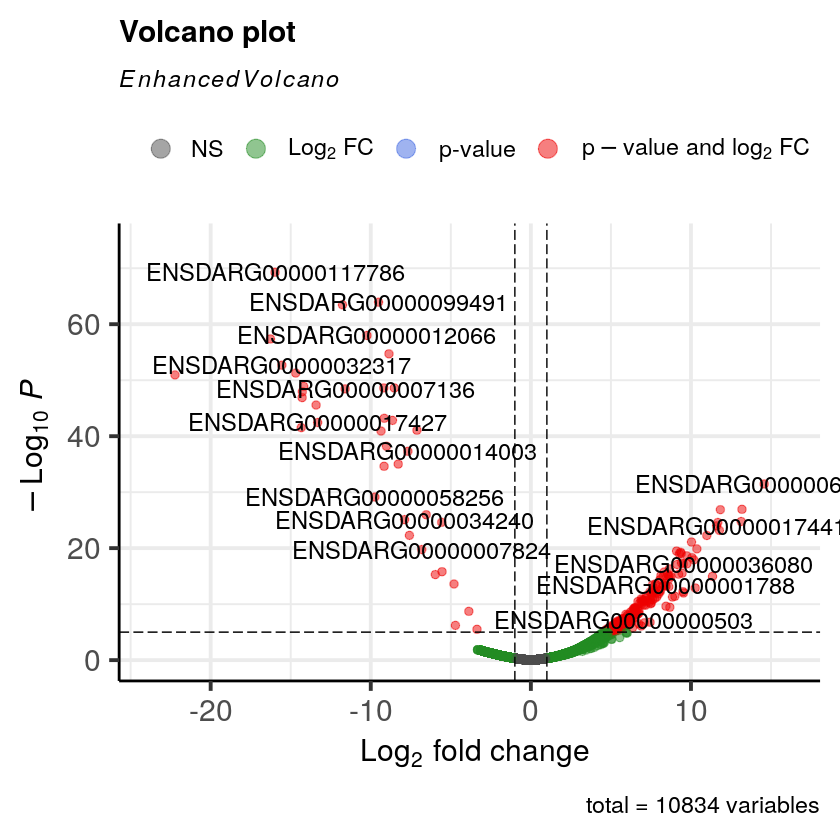

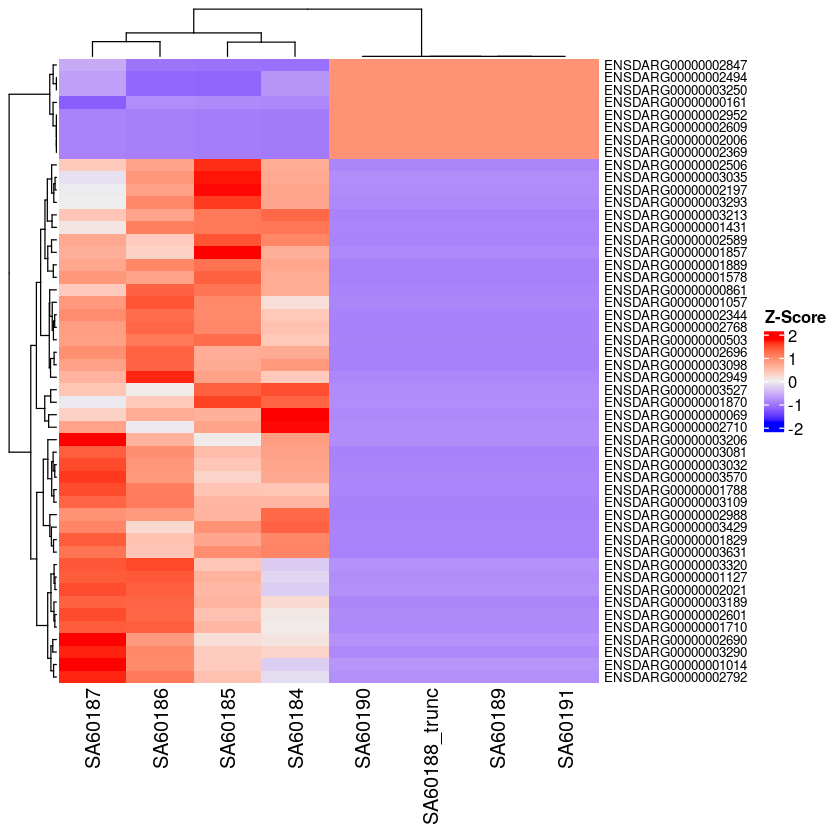

In [43]:
#volcano and ma plots can be used to visualize significant differences in gene expression
results_volc_df <- results.annot
EnhancedVolcano(results_volc_df,
    lab = results_volc_df[,1],
    x = 'log2FoldChange',
    y = 'padj')

#ma plot
plotMA(res_WT_WHIM)


#heatmaps can used to look at clustering and expression of various gene lists.
filtered_res <- results.annot %>% filter(padj < 0.05)
filtered_res_counts <- subset(rlogcounts, rownames(rlogcounts) %in% filtered_res[,1])
filtered_res_counts = t(scale(t(filtered_res_counts)))
Heatmap(filtered_res_counts[1:50,], name = "Z-Score", row_names_gp = gpar(fontsize = 8))